In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
from bs4 import BeautifulSoup
import pandas_datareader as dr
import statistics
from sklearn import linear_model
from sklearn.metrics import r2_score

In [44]:
#Get's the Stock Sticker the user wants
user_stock = input("Pick a Dividend Paying Stock's Ticker Symbol: ")
#Make if else statement that only accepts kings or aristocrates
user_stock = user_stock.upper()

Pick a Dividend Paying Stock's Ticker Symbol: dis


In [45]:
#Gets the string format for Dates
def Dates(date):
    dateString = ''
    for val in str(date):
        if(val == ' '):
            break
        elif(val == '-'):
            dateString = dateString + '/'   
        else:
            dateString = dateString + val
            
    return dateString

In [46]:
#Makes an array that has the desired data for all important items we want to graph
def locator(locator_array,data_array):
    desired_array = []
    desired_array2 = []
    desired_array3 = []
    
# Gets the locations of the data we want in the financial tablet   
    for location in locator_array:
        for value in range(0,5,1):
            desired_array.append(data_array[location+value])
            
# Converts the data that is negative into a readable negative strings            
    for value in desired_array:
        if(value.startswith('(') == True):
            value = value[1:-1]
            value = '-'+ value
        else:
            pass
        desired_array2.append(value)
        
# Converts the into useable numerical values        
    for item in desired_array2:
        if(str(item[-1]) == 'B'):
            item = float(item[0:-1]) * 1000000000
        elif(str(item[-1]) == 'M'):
            item = float(item[0:-1]) * 1000000
        elif(str(item[-1]) == 'T'):
            item = float(item[0:-1]) * 1000000000000
        elif(str(item) == '-'):
            item = np.NaN
        else:
            temp = ''
            for char in item:
                item = item.split(',')
                for i in item:
                    temp += i
                item = float(temp)
        desired_array3.append(item)
            
    return desired_array3

In [47]:
#This Function is for the 3 valuation ratios
def ValuationRatios(soup):
    finder = []
    holder = []
    
    for value in soup.find_all('td',style = 'text-align:center;'):
        finder.append(value.text)
        
    for index in range(3,len(finder),4):
        holder.append(float(finder[index]))
        
    return holder

In [48]:
#Gets the soup for the link provided
def SoupGetter(searchVar):
    source = requests.get(searchVar).text
    soup = BeautifulSoup(source,'lxml')
    return soup

In [49]:
#Gets stock price over a certain of time the user wants

#Gets today's date
today_time = datetime.datetime.now()
today_date = Dates(pd.to_datetime(today_time,yearfirst = True))

#Gets the date One Year ago
oneYr_date = Dates(datetime.datetime.now() - datetime.timedelta(days = 1 * 365))

#Gets the date Three Years ago
threeYr_date = Dates(datetime.datetime.now() - datetime.timedelta(days = 3 * 365))

#Gets the date Five Years ago
fivYr_date = Dates(datetime.datetime.now() - datetime.timedelta(days = 5 * 365))
        
#Gets the date Ten Years ago
tenYr_date = Dates(datetime.datetime.now() - datetime.timedelta(days = 10 * 365))

#Stock Prices for 1 Year
oneYr_stock_prices = dr.get_data_yahoo('{}'.format(user_stock), start = oneYr_date, end = today_date)

#Stock Prices for 3 Years
threeYr_stock_prices = dr.get_data_yahoo('{}'.format(user_stock), start = threeYr_date, end = today_date)

#Stock Prices for 5 Years
fivYr_stock_prices = dr.get_data_yahoo('{}'.format(user_stock), start = fivYr_date, end = today_date)

#Stock Prices for 10 Years
tenYr_stock_prices = dr.get_data_yahoo('{}'.format(user_stock), start = tenYr_date, end = today_date)

#Gets Today's date in string format for dividend webscrape in epoch time
epochToday = str(int(datetime.datetime(int(today_date[0:4]),int(today_date[5:7]),int(today_date[8:10]),0,0).timestamp()))

print(epochToday)

1595142000


In [50]:
#Gets the years for the graphs
year = int(datetime.datetime.now().year) - 1
years = [year,year-1,year-2,year-3,year-4]
years = [str(i) for i in years]
years

['2019', '2018', '2017', '2016', '2015']

In [51]:
#Web Scrapes the Balance Sheet that is for Annual Data

#Requests balance sheet data from market watch
balance_sheet_soup = SoupGetter(searchVar = 'https://www.marketwatch.com/investing/stock/{0}/financials/balance-sheet'.format(user_stock))

#Finds the row numbers for the data we want
truth_checker = []
balance_sheet_loc = []
bs_count = 0
for value in balance_sheet_soup.find_all('td',class_ = 'rowTitle'):
    if(str(value.text) == ' Cash & Short Term Investments'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(0)
    elif(str(value.text) == ' Total Accounts Receivable'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(1)
    elif(str(value.text) == 'Total Current Assets'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(2)
    elif(str(value.text) == ' Total Assets'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(3)
    elif(str(value.text) == 'Short Term Debt'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(4)
    elif(str(value.text) == ' Total Current Liabilities'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(5)
    elif(str(value.text) == 'Long-Term Debt'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(6)
    elif(str(value.text) == ' Total Liabilities'):
        balance_sheet_loc.append(bs_count)
        truth_checker.append(7)
    else:
        pass
    bs_count += 5
    
#Finds numeric value for missing categories
lost_values_beta = [0,1,2,3,4,5,6,7]
lost_values = []

for value in lost_values_beta:
    if((value in truth_checker) == True):
        pass
    else:
        lost_values.append(value)
        
lost_values = [i*5 for i in lost_values]

#Collects the financial number for the balance sheet 
balance_sheet1 = []
for text in balance_sheet_soup.find_all('td',class_ = 'valueCell'):
    balance_sheet1.append(text.text)
    
#Does the neccessary Transformations to balance sheet data
balanceSheetData = locator(balance_sheet_loc,balance_sheet1)

#Puts in NaNs for the lost values locations
for lv in lost_values:
    balanceSheetData.insert(lv,np.NaN)
    balanceSheetData.insert(lv+1,np.NaN)
    balanceSheetData.insert(lv+2,np.NaN)
    balanceSheetData.insert(lv+3,np.NaN)
    balanceSheetData.insert(lv+4,np.NaN)


#Creates the actual data frame based on the balance sheet
balanceSheet = pd.DataFrame({'Cash_&_Short_Term_Investments':balanceSheetData[0:5],
                            'Total_Accounts_Receivable':balanceSheetData[5:10],
                             'Total_Current_Assets':balanceSheetData[10:15],
                             'Total_Assets':balanceSheetData[15:20],
                             'Short_Term_Debt':balanceSheetData[20:25],
                             'Total_Current_Liabilities':balanceSheetData[25:30],
                             'Long_Term_Debt':balanceSheetData[30:35],
                             'Total_Liabilities':balanceSheetData[35:40]
                            })

print(balanceSheet)



   Cash_&_Short_Term_Investments  Total_Accounts_Receivable  \
0                   4.270000e+09               8.020000e+09   
1                   4.610000e+09               9.070000e+09   
2                   4.020000e+09               8.630000e+09   
3                   4.150000e+09               9.330000e+09   
4                   5.420000e+09               1.548000e+10   

   Total_Current_Assets  Total_Assets  Short_Term_Debt  \
0          1.559000e+10  8.818000e+10              NaN   
1          1.576000e+10  9.203000e+10              NaN   
2          1.461000e+10  9.579000e+10              NaN   
3          1.551000e+10  9.860000e+10              NaN   
4          2.353000e+10  1.939800e+11              NaN   

   Total_Current_Liabilities  Long_Term_Debt  Total_Liabilities  
0               1.633000e+10    1.277000e+10       3.953000e+10  
1               1.684000e+10    1.648000e+10       4.471000e+10  
2               1.960000e+10    1.912000e+10       4.964000e+10  
3       

In [52]:
#Creates Data frame for Income Statement

#create function that auto scrapes market watch
financial_statement_soup = SoupGetter(searchVar = 'https://www.marketwatch.com/investing/stock/{0}/financials'.format(user_stock))

#Finds rows of the data we want for the Income Statement
truth_checker2 = []
income_statement_loc = []
is_count = 0

for value in financial_statement_soup.find_all('td',class_ = 'rowTitle'):
    if(str(value.text) == ' Cost of Goods Sold (COGS) incl. D&A'):
        income_statement_loc.append(is_count)
        truth_checker2.append(0)
    elif(str(value.text) == ' Gross Income'):
        income_statement_loc.append(is_count)
        truth_checker2.append(1)
    elif(str(value.text) == ' SG&A Expense'):
        income_statement_loc.append(is_count)
        truth_checker2.append(2)
    elif(str(value.text) == ' Interest Expense'):
        income_statement_loc.append(is_count)
        truth_checker2.append(3)
    elif(str(value.text) == ' Pretax Income'):
        income_statement_loc.append(is_count)
        truth_checker2.append(4)
    elif(str(value.text) == ' Net Income'):
        income_statement_loc.append(is_count)
        truth_checker2.append(5)
    elif(str(value.text) == ' EBITDA'):
        income_statement_loc.append(is_count)
        truth_checker2.append(6)
    else:
        pass
    is_count += 5
    
lost_values_beta2 = [0,1,2,3,4,5,6,7]
lost_values2 = []
#Finds numeric value for missing categories
for value in lost_values_beta2:
    if((value in truth_checker2) == True):
        pass
    else:
        lost_values2.append(value)
        

lost_values2 = [i*5 for i in lost_values2]
    
#Collects the financial number for the Income Statement
income_statement1 = []
for var in financial_statement_soup.find_all('td',class_ = 'valueCell'):
    income_statement1.append(var.text)
    
#Does the neccessary Transformations to Income Statement
incomeStatementData = locator(income_statement_loc,income_statement1)

#Puts in NaNs for the lost values locations
for lv in lost_values2:
    incomeStatementData.insert(lv,np.NaN)
    incomeStatementData.insert(lv+1,np.NaN)
    incomeStatementData.insert(lv+2,np.NaN)
    incomeStatementData.insert(lv+3,np.NaN)
    incomeStatementData.insert(lv+4,np.NaN)
    

#Creates the actual data frame based on the balance sheet
incomeStatement = pd.DataFrame({'Cost_of_Goods_Sold':incomeStatementData[0:5],
                             'Gross_Income':incomeStatementData[5:10],
                             'SG&A_Expense':incomeStatementData[10:15],
                             'Interest_Expense':incomeStatementData[15:20],
                             'Pretax_Income':incomeStatementData[20:25],
                             'Net_Income':incomeStatementData[25:30],
                             'EBITDA':incomeStatementData[30:35]
                            })

print(incomeStatement)

   Cost_of_Goods_Sold  Gross_Income  SG&A_Expense  Interest_Expense  \
0        3.064000e+10  2.137000e+10  8.520000e+09      4.510000e+08   
1        3.236000e+10  2.301000e+10  8.750000e+09      4.460000e+08   
2        3.296000e+10  2.199000e+10  8.180000e+09      5.400000e+08   
3        3.570000e+10  2.377000e+10  8.860000e+09      7.060000e+08   
4        4.611000e+10  2.327000e+10  1.154000e+10      1.260000e+09   

   Pretax_Income    Net_Income        EBITDA  
0   1.387000e+10  8.380000e+09  1.520000e+10  
1   1.487000e+10  9.390000e+09  1.679000e+10  
2   1.379000e+10  8.980000e+09  1.659000e+10  
3   1.473000e+10  1.260000e+10  1.793000e+10  
4   1.394000e+10  1.044000e+10  1.589000e+10  


In [53]:
#create function that auto scrapes market watch
cash_flow_soup = SoupGetter(searchVar = 'https://www.marketwatch.com/investing/stock/{0}/financials/cash-flow'.format(user_stock))

#finds location of cashflow's important variables
truth_checker3 = []
cash_flow_loc = []
cf_count = 0
for i in cash_flow_soup.find_all('td',class_ = 'rowTitle'):
    if(str(i.text) == ' Net Operating Cash Flow'):
        cash_flow_loc.append(cf_count)
        truth_checker3.append(0)
    elif(str(i.text) == ' Net Investing Cash Flow'):
        cash_flow_loc.append(cf_count)
        truth_checker3.append(1)
    elif(str(i.text) == ' Net Financing Cash Flow'):
        cash_flow_loc.append(cf_count)
        truth_checker3.append(2)
    elif(str(i.text) == ' Free Cash Flow'):
        cash_flow_loc.append(cf_count)
        truth_checker3.append(3)
    else:
        pass
    cf_count += 5

#Finds numeric value for missing categories
lost_values_beta3 = [0,1,2,3]
lost_values3 = []
for value in lost_values_beta3:
    if((value in truth_checker3) == True):
        pass
    else:
        lost_values3.append(value)

lost_values3 = [i*5 for i in lost_values3]    

#Collects the financial number for the cash flow
cash_flow1 = []
for var in cash_flow_soup.find_all('td',class_ = 'valueCell'):
    cash_flow1.append(var.text)
    
#Neccessary transformations on the cash flow data
cashFlowData = locator(cash_flow_loc,cash_flow1)

#Puts in NaNs for the lost values locations
for lv in lost_values3:
    cashFlowData.insert(lv,np.NaN)
    cashFlowData.insert(lv+1,np.NaN)
    cashFlowData.insert(lv+2,np.NaN)
    cashFlowData.insert(lv+3,np.NaN)
    cashFlowData.insert(lv+4,np.NaN)

cashFlow = pd.DataFrame({'Net_Operating_Cash_Flow':cashFlowData[0:5],
                        'Net_Investing_Cash_Flow':cashFlowData[5:10],
                        'Net_Financing_Cash_Flow':cashFlowData[10:15],
                        'Free_Cash_Flow':cashFlowData[15:20]})
print(cashFlow)

   Net_Operating_Cash_Flow  Net_Investing_Cash_Flow  Net_Financing_Cash_Flow  \
0             1.091000e+10            -3.230000e+09            -6.530000e+09   
1             1.321000e+10            -5.760000e+09            -6.990000e+09   
2             1.234000e+10            -4.090000e+09            -8.980000e+09   
3             1.430000e+10            -4.940000e+09            -9.240000e+09   
4             6.610000e+09            -4.810000e+09            -3.970000e+08   

   Free_Cash_Flow  
0    6.640000e+09  
1    8.440000e+09  
2    8.720000e+09  
3    9.830000e+09  
4    1.730000e+09  


In [54]:
#Gets the dividend data from Yahoo finance from today's date to 20 Years ago 

divSoup = SoupGetter('https://finance.yahoo.com/quote/{0}/history?period1=946684800&period2={1}&interval=div%7Csplit&filter=div&frequency=1d'.format(user_stock,epochToday))

#This for loop acquires the dividend by the quarter
dividends = []
for i in divSoup.find_all('td',class_ = 'Ta(c) Py(10px) Pstart(10px)'):
    div = i.text
    div = div.split(' ')
    divCount = 0
    for val in div:
        if(divCount == 0):
            dividends.append(float(val))
            divCount += 1
        else:
            divCount -= 1
            
#This for loop gets the years together
dividendDates = []
for date in divSoup.find_all('td',class_ = 'Py(10px) Ta(start) Pend(10px)'):
    dividendDates.append(date.text[8:12])
    
#ideal Dataframes for dividends
dividendDataframe = pd.DataFrame({'Dates':np.flip(dividendDates),
                                 'Dividends':np.flip(dividends)})

dividendDataFrame = pd.DataFrame({'Years':pd.unique(dividendDataframe['Dates']),
                                  'Dividends':dividendDataframe.groupby('Dates')['Dividends'].sum()})

dividendDataFrame = dividendDataFrame[:-1]

print(dividendDataFrame)        

#Calculates dividend perecent change for graphs
dividendPercent = [100*i for i in dividendDataFrame['Dividends'].pct_change()]

ValueError: could not convert string to float: 

In [55]:
#Webscrapes for the name of stock
name_soup = SoupGetter(searchVar = 'https://www.cnbc.com/quotes/?symbol={0}'.format(user_stock))

#Gets the company name we need to webscrape
CompanyName = name_soup.find(class_ = 'name').text.lower()
splitName = CompanyName.split(' ')

try:
    compName = splitName[0]
    
except:
    compName = CompanyName.replace(' ','-')

#Webscrapes for pe ratios
PBs = ValuationRatios(SoupGetter(searchVar = 'https://www.macrotrends.net/stocks/charts/{0}/{1}/price-book'.format(user_stock,compName)))

#Webscrapes for ps ratios
PSs = ValuationRatios(SoupGetter(searchVar = 'https://www.macrotrends.net/stocks/charts/{0}/{1}/price-sales'.format(user_stock,compName)))

#Webscrapes the PEs in the data
PEs = ValuationRatios(SoupGetter(searchVar = 'https://www.macrotrends.net/stocks/charts/{0}/{1}/pe-ratio'.format(user_stock,compName)))


In [56]:
#Webscrapes quarterly and annual EPS of a stock
EPS_soup = SoupGetter(searchVar = 'https://www.macrotrends.net/stocks/charts/{0}/{1}/eps-earnings-per-share-diluted'.format(user_stock,compName))

EPSfinder = []
EPSdates = []
EPSdollar = []

#Gets the EPS data from macrotrends.com
for value in EPS_soup.find_all('td',style = 'text-align:center'):
    EPSfinder.append(value.text)

#Gets the money by the quarter
for val in range(0,len(EPSfinder),1):
    if(('-' in EPSfinder[val]) and ('$' not in EPSfinder[val])):
        try:
            EPSdollar.append(float(EPSfinder[val+1][1:]))
        except:
            pass
    else: pass
        
#Gets the dates by the quarter 
for date in range(0,len(EPSfinder),1):
    if(('-' in EPSfinder[date]) and (' ' not in EPSfinder[date]) and ('$' not in EPSfinder[date])):
        EPSdates.append(EPSfinder[date])
    else: pass
    
#Gets the Years by themselves
EPSyears = [i[0:4] for i in EPSdates]    

#Yearly EPS dataframe 
yearlyEPS = pd.DataFrame({'EPS':np.flip(EPSdollar),
                          'Date':np.flip(EPSyears)})

yearlyEPS = pd.DataFrame({'EPS':yearlyEPS.groupby('Date')['EPS'].sum(),
                         'Date':pd.unique(yearlyEPS['Date'])})

yearlyEPS = yearlyEPS[:-1]

#Quarterly EPS dataframe
EPSquarts = pd.to_datetime(EPSdates)

quarterlyEPS = pd.DataFrame({'EPS':np.flip(EPSdollar),
                            'Dates':np.flip(EPSquarts),
                            'num':[number for number in range(0,len(EPSdollar),1)]})


# Gets the percentage change for Yearly 
epsPercentYearly = [100*i for i in yearlyEPS['EPS'].pct_change()]
epsPercentQuarterly = [100*i for i in quarterlyEPS['EPS'].pct_change()]

print(epsPercentYearly)

[nan, 63.49206349206354, 1.4563106796116498, 0.4784688995215447, -16.666666666666675, 29.714285714285715, 16.299559471365633, 17.045454545454565, 17.79935275080904, 23.351648351648358, 19.376391982182618, 3.5447761194030036, 27.027027027027017, 3.687943262411353, -18.741450068399466]


In [57]:
#Wbescrapes General Information
gen_soup = SoupGetter(searchVar = 'https://finance.yahoo.com/quote/{0}?p={0}'.format(user_stock))    

genData = []
for i in gen_soup.find_all('td',class_ = 'Ta(end) Fw(600) Lh(14px)'):
    genData.append(i.text)
    
for i in gen_soup.find_all('h1',class_ = 'D(ib) Fz(18px)'):
    print(i.text)

#Makes all values in one year range into a float
oneYrPrices = [float(i) for i in oneYr_stock_prices['Close']]

print('Market Cap: ' + genData[8])
print('Beta: ' + genData[9])
print('PE Ratio: ' + genData[10])
print('EPS: ' + genData[11])
print('52 Week Range: $', np.amin(oneYrPrices),'- $',np.amax(oneYrPrices)) 



Market Cap: 214.314B
Beta: 1.11
PE Ratio: 39.96
EPS: 2.97
52 Week Range: $ 85.76000213623047 - $ 151.63999938964844


Text(0.5, 1.0, "DIS's 10 Year Stock Price")

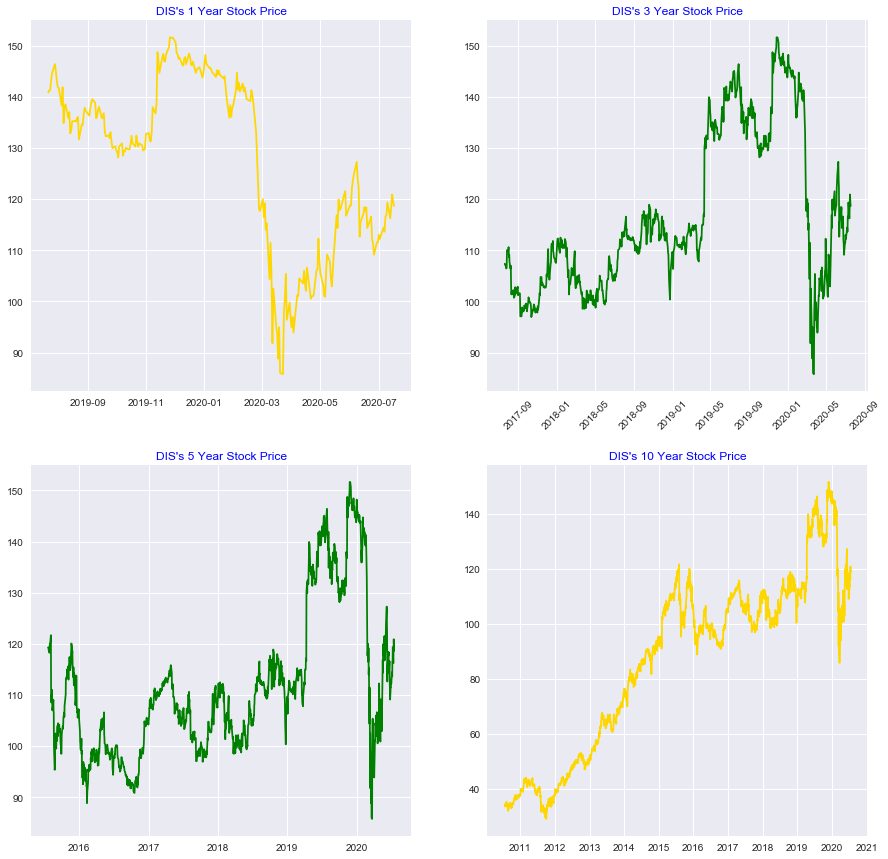

In [58]:
fig,ax5 = plt.subplots(nrows = 2,ncols = 2,figsize = (15,15))

#Makes the stock price plot over 1 year
ax5[0,0].plot(oneYr_stock_prices.index.values,
              oneYr_stock_prices['Close'],
              color = 'gold')
ax5[0,0].set_title("{0}'s 1 Year Stock Price".format(user_stock),color = 'b')

#Makes the stock price plot over 3 years
ax5[0,1].plot(threeYr_stock_prices.index.values,
              threeYr_stock_prices['Close'],
              color = 'green')
ax5[0,1].set_title("{0}'s 3 Year Stock Price".format(user_stock),color = 'b')

plt.setp(ax5[0,1].get_xticklabels(), rotation=45)

#Makes the stock price plot over 5 years
ax5[1,0].plot(fivYr_stock_prices.index.values,
              fivYr_stock_prices['Close'],
              color = 'green')
ax5[1,0].set_title("{0}'s 5 Year Stock Price".format(user_stock),color = 'b')

#Makes the stock price plot over 10 years
ax5[1,1].plot(tenYr_stock_prices.index.values,
              tenYr_stock_prices['Close'],
              color = 'gold')
ax5[1,1].set_title("{0}'s 10 Year Stock Price".format(user_stock),color = 'b')



In [59]:
#General Dividend Information

dividendData = genData[13].split(' ')

#Checks if there is a dividend or not
if(dividendData[0][0:-1] == 'N/'):
    dividend = 0
else:
    dividend = float(dividendData[0][0:-1])
    
try:
    payoutRatio = dividend/float(genData[11])
except:
    payoutRatio = 'N/A'


try:
    if(len(dividendPercent) >= 5):
        FivDiv = statistics.mean(dividendPercent[-6:-1])
    else:
        FivDiv = statistics.mean(dividendPercent)
        
except:
    FivDiv = 0
    
try:
    if(len(dividendPercent) >= 10):
        TenDiv = statistics.mean(dividendPercent[-11:-1])
    else:
        TenDiv = statistics.mean(dividendPercent)
        
except:
    TenDiv = 0

print('Payout Ratio', payoutRatio)
print('Dividend(Annual): $',dividend)
print('Dividend Yield',dividendData[1][1:-1])
print('3 Year Dividend Growth Rate: ',(sum(dividendPercent[-3:])/3),'%')
print('5 Year Dividend Growth Rate: ',(sum(dividendPercent[-5:])/5),'%')
print('10 Year Dividend Growth Rate: ',(sum(dividendPercent[-10:])/10),'%')

Payout Ratio 0.0
Dividend(Annual): $ 0
Dividend Yield N/A
3 Year Dividend Growth Rate:  8.642645420417304 %
5 Year Dividend Growth Rate:  8.442217675668504 %
10 Year Dividend Growth Rate:  8.460172060986249 %


Text(0.5, 0, 'Years')

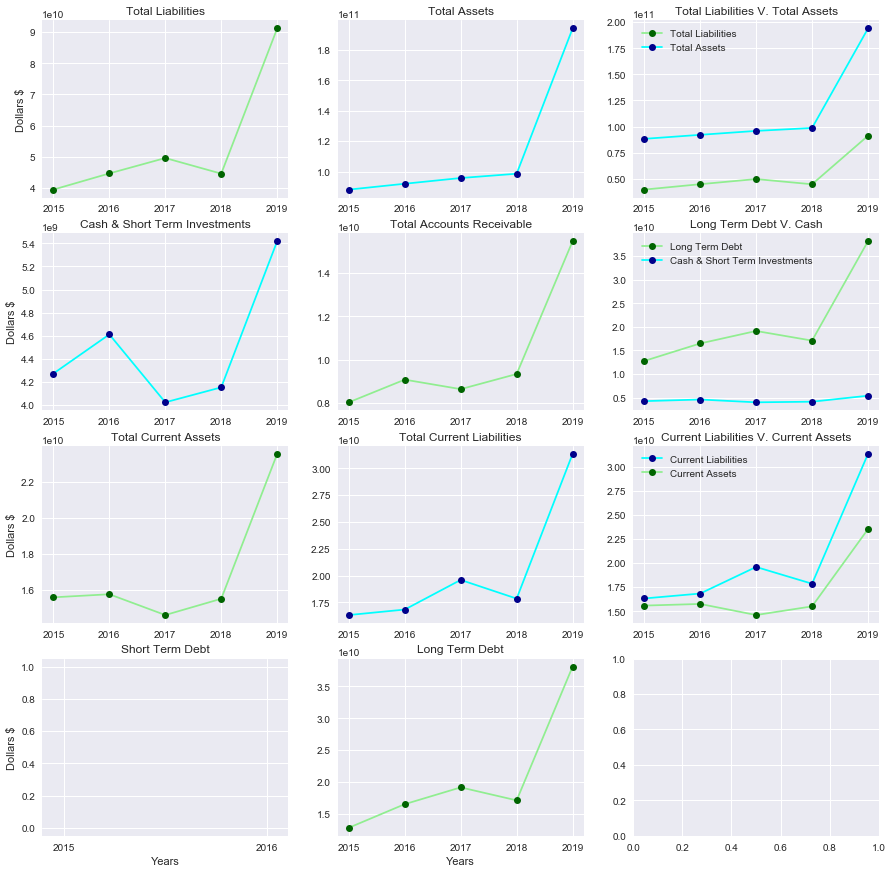

In [60]:
#Balance Sheet subplots
plt.style.use('seaborn')
fig,ax1 = plt.subplots(nrows = 4,ncols = 3,figsize = (15,15))

ax1[0,0].plot(np.flip(years),balanceSheet['Total_Liabilities'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax1[0,0].set_title('Total Liabilities')

ax1[0,1].plot(np.flip(years),balanceSheet['Total_Assets'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax1[0,1].set_title('Total Assets')

ax1[0,2].plot(np.flip(years),balanceSheet['Total_Liabilities'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen',label = 'Total Liabilities')
ax1[0,2].plot(np.flip(years),balanceSheet['Total_Assets'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue',label = 'Total Assets')
ax1[0,2].set_title('Total Liabilities V. Total Assets')
ax1[0,2].legend()

ax1[1,0].plot(np.flip(years),balanceSheet['Cash_&_Short_Term_Investments'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax1[1,0].set_title('Cash & Short Term Investments')

ax1[1,1].plot(np.flip(years),balanceSheet['Total_Accounts_Receivable'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax1[1,1].set_title('Total Accounts Receivable')

ax1[1,2].plot(np.flip(years),balanceSheet['Long_Term_Debt'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen',label = 'Long Term Debt')
ax1[1,2].plot(np.flip(years),balanceSheet['Cash_&_Short_Term_Investments'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue', label = 'Cash & Short Term Investments')
ax1[1,2].set_title('Long Term Debt V. Cash')
ax1[1,2].legend()

ax1[2,1].plot(np.flip(years),balanceSheet['Total_Current_Liabilities'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax1[2,1].set_title('Total Current Liabilities')

ax1[2,0].plot(np.flip(years),balanceSheet['Total_Current_Assets'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax1[2,0].set_title('Total Current Assets')

ax1[2,2].plot(np.flip(years),balanceSheet['Total_Current_Liabilities'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue',label = 'Current Liabilities')
ax1[2,2].plot(np.flip(years),balanceSheet['Total_Current_Assets'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen',label = 'Current Assets')
ax1[2,2].set_title('Current Liabilities V. Current Assets')
ax1[2,2].legend()

ax1[3,0].plot(np.flip(years),balanceSheet['Short_Term_Debt'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax1[3,0].set_title('Short Term Debt')

ax1[3,1].plot(np.flip(years),balanceSheet['Long_Term_Debt'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax1[3,1].set_title('Long Term Debt')



ax1[0,0].set_ylabel('Dollars $')
ax1[1,0].set_ylabel('Dollars $')
ax1[2,0].set_ylabel('Dollars $')
ax1[3,0].set_ylabel('Dollars $')

ax1[3,0].set_xlabel('Years')
ax1[3,1].set_xlabel('Years')


Text(0.5, 0, 'Years')

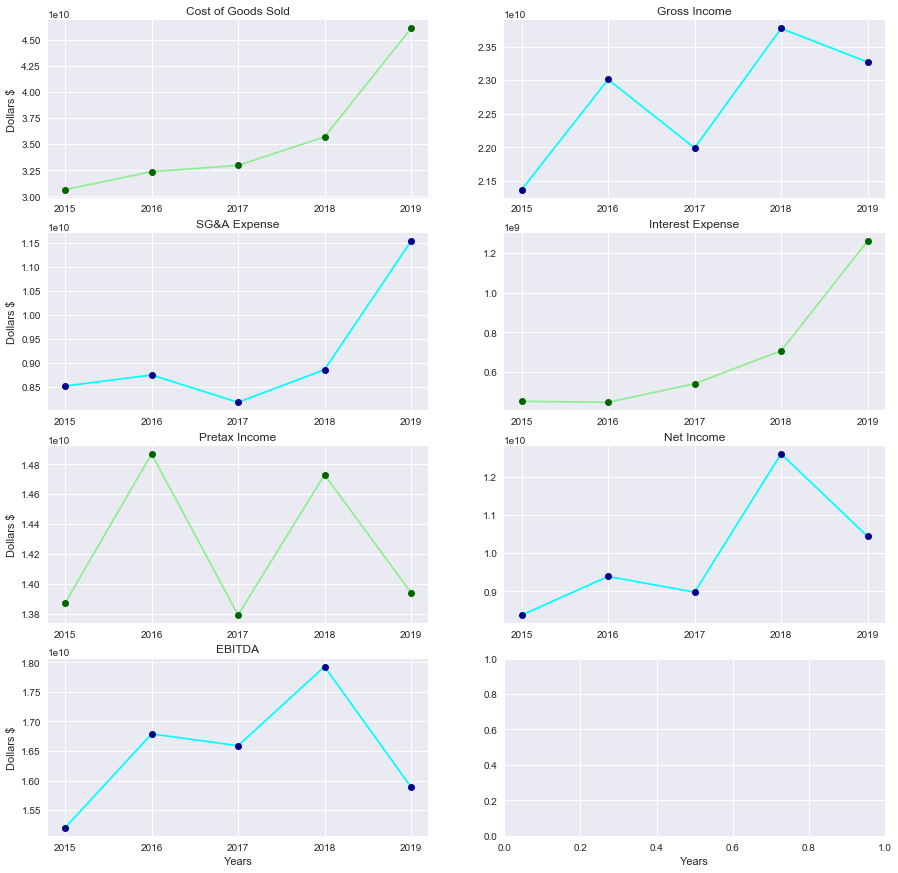

In [61]:
#Subplots for Income Statement
plt.style.use('seaborn')
fig,ax2 = plt.subplots(nrows = 4,ncols = 2,figsize = (15,15))

ax2[0,0].plot(np.flip(years),incomeStatement['Cost_of_Goods_Sold'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax2[0,0].set_title('Cost of Goods Sold')

ax2[0,1].plot(np.flip(years),incomeStatement['Gross_Income'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax2[0,1].set_title('Gross Income')

ax2[1,0].plot(np.flip(years),incomeStatement['SG&A_Expense'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax2[1,0].set_title('SG&A Expense')

ax2[1,1].plot(np.flip(years),incomeStatement['Interest_Expense'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax2[1,1].set_title('Interest Expense')

ax2[2,0].plot(np.flip(years),incomeStatement['Pretax_Income'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax2[2,0].set_title('Pretax Income')

ax2[2,1].plot(np.flip(years),incomeStatement['Net_Income'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax2[2,1].set_title('Net Income')

ax2[3,0].plot(np.flip(years),incomeStatement['EBITDA'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax2[3,0].set_title('EBITDA')

ax2[0,0].set_ylabel('Dollars $')
ax2[1,0].set_ylabel('Dollars $')
ax2[2,0].set_ylabel('Dollars $')
ax2[3,0].set_ylabel('Dollars $')

ax2[3,0].set_xlabel('Years')
ax2[3,1].set_xlabel('Years')

Text(0.5, 0, 'Years')

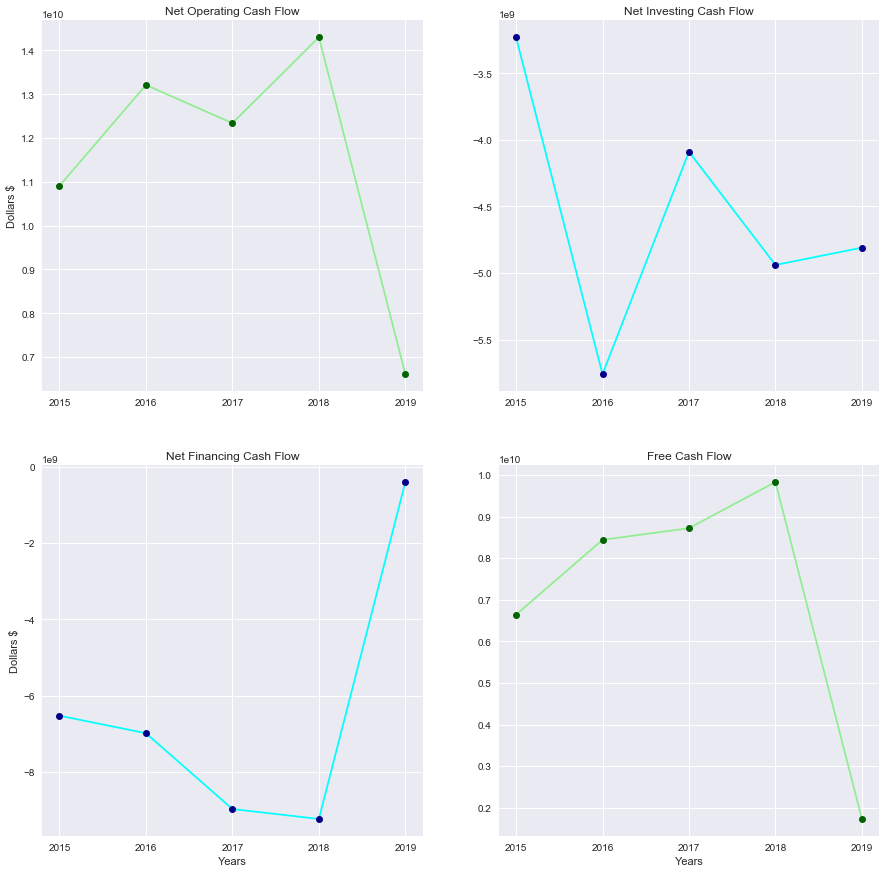

In [62]:
#Cash Flow Graphs
plt.style.use('seaborn')
fig,ax3 = plt.subplots(nrows = 2,ncols = 2,figsize = (15,15))

ax3[0,0].plot(np.flip(years),cashFlow['Net_Operating_Cash_Flow'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax3[0,0].set_title('Net Operating Cash Flow')
ax3[0,0].set_ylabel('Dollars $')

ax3[0,1].plot(np.flip(years),cashFlow['Net_Investing_Cash_Flow'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax3[0,1].set_title('Net Investing Cash Flow')

ax3[1,0].plot(np.flip(years),cashFlow['Net_Financing_Cash_Flow'],color = 'cyan',marker = 'o',markerfacecolor = 'darkblue')
ax3[1,0].set_title('Net Financing Cash Flow')
ax3[1,0].set_ylabel('Dollars $')
ax3[1,0].set_xlabel('Years')

ax3[1,1].plot(np.flip(years),cashFlow['Free_Cash_Flow'],color = 'lightgreen',marker = 'o',markerfacecolor = 'darkgreen')
ax3[1,1].set_title('Free Cash Flow')
ax3[1,1].set_xlabel('Years')

Text(0.5, 1.0, "DIS's Dividend % Change Year Over Year (5 Yrs)")

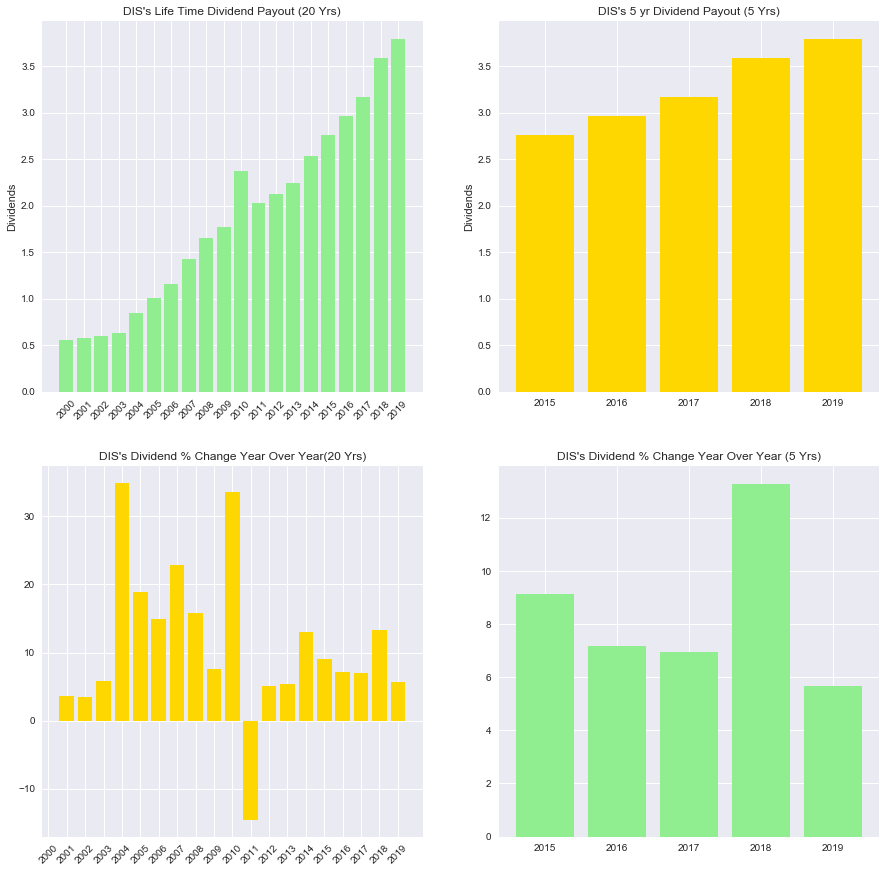

In [63]:
# Dividend Graphs
plt.style.use('seaborn')
fig,ax4 = plt.subplots(nrows = 2,ncols = 2,figsize = (15,15))

#Outputs lifetime Dividends
ax4[0,0].bar(dividendDataFrame['Years'],dividendDataFrame['Dividends'],color = 'lightgreen')
ax4[0,0].set_title("{0}'s Life Time Dividend Payout (20 Yrs)".format(user_stock))
ax4[0,0].set_ylabel('Dividends')
plt.setp(ax4[0,0].get_xticklabels(), rotation=45)

#Makes the last 5 year raw dividend graphs
ax4[0,1].bar(dividendDataFrame['Years'][-5:],dividendDataFrame['Dividends'][-5:],color = 'gold')
ax4[0,1].set_title("{0}'s 5 yr Dividend Payout (5 Yrs)".format(user_stock))
ax4[0,1].set_ylabel('Dividends')

#Get the percent for the lifetime years for dividends
ax4[1,0].bar(dividendDataFrame['Years'],dividendPercent,color = 'gold')
ax4[1,0].set_title("{0}'s Dividend % Change Year Over Year(20 Yrs)".format(user_stock))
plt.setp(ax4[1,0].get_xticklabels(), rotation=45)

#Get the percent for 5 years for dividends
ax4[1,1].bar(dividendDataFrame['Years'][-5:],dividendPercent[-5:],color = 'lightgreen')
ax4[1,1].set_title("{0}'s Dividend % Change Year Over Year (5 Yrs)".format(user_stock))



PE Ratio 5 Number Summary: 
count    55.000000
mean     16.433455
std       5.059820
min       8.610000
25%      13.455000
50%      15.190000
75%      18.475000
max      40.080000
dtype: float64
PB Ratio 5 Number Summary: 
count    58.000000
mean      2.268793
std       0.794070
min       0.870000
25%       1.665000
50%       1.965000
75%       3.042500
max       3.720000
dtype: float64
PS Ratio 5 Number Summary: 
count    55.000000
mean      2.282545
std       0.745488
min       0.830000
25%       1.630000
50%       2.380000
75%       2.955000
max       3.610000
dtype: float64


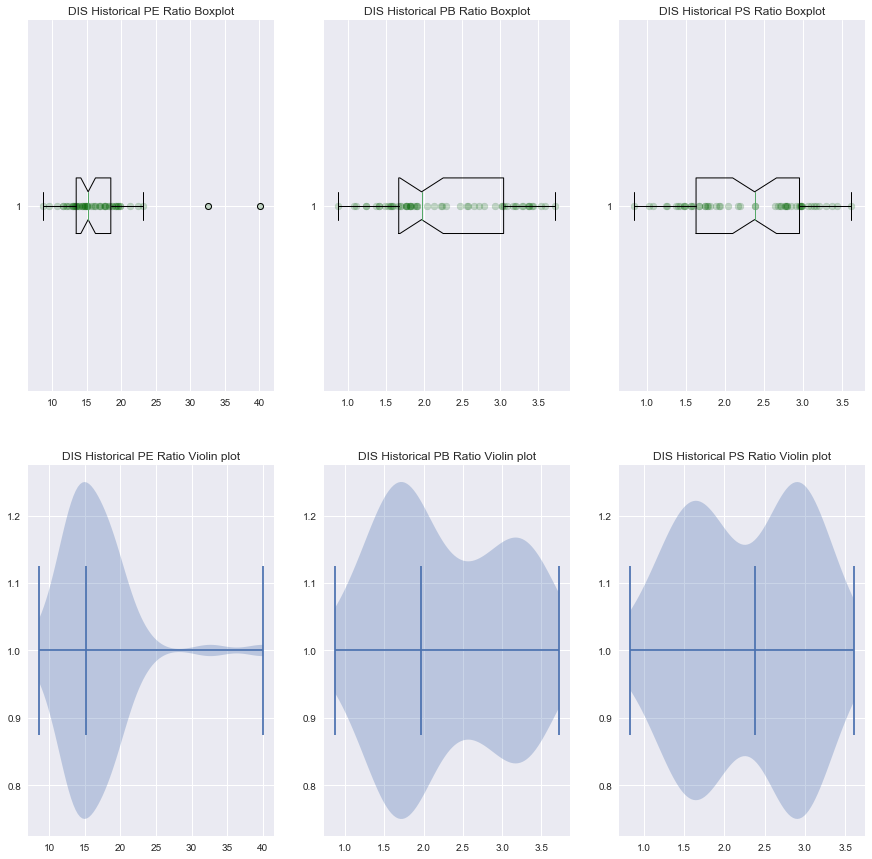

In [64]:
#Creates a sequence of 1s for dots on the boxplots
PESeq = [1 for i in range(0,len(PEs),1)]
PBSeq = [1 for i in range(0,len(PBs),1)]
PSSeq = [1 for i in range(0,len(PSs),1)]

#Plots for Valuation Ratios
plt.style.use('seaborn')
fig,ax6 = plt.subplots(nrows = 2,ncols = 3,figsize = (15,15))

#BoxPlots for valuation ratios

#PE Boxplot
ax6[0,0].boxplot(PEs, notch = True,vert = False)
ax6[0,0].scatter(PEs,PESeq,color = 'darkgreen',alpha = .2)
ax6[0,0].set_title('{0} Historical PE Ratio Boxplot'.format(user_stock))

#PB Boxplots
ax6[0,1].boxplot(PBs, notch = True,vert = False)
ax6[0,1].scatter(PBs,PBSeq,color = 'darkgreen',alpha = .2)
ax6[0,1].set_title('{0} Historical PB Ratio Boxplot'.format(user_stock))

#PS Boxplots
ax6[0,2].boxplot(PSs, notch = True,vert = False)
ax6[0,2].scatter(PSs,PSSeq,color = 'darkgreen',alpha = .2)
ax6[0,2].set_title('{0} Historical PS Ratio Boxplot'.format(user_stock))

#PE Violinplot
ax6[1,0].violinplot(PEs,vert = False, showmedians = True)
ax6[1,0].set_title('{0} Historical PE Ratio Violin plot'.format(user_stock))

ax6[1,1].violinplot(PBs,vert = False, showmedians = True)
ax6[1,1].set_title('{0} Historical PB Ratio Violin plot'.format(user_stock))

ax6[1,2].violinplot(PSs,vert = False, showmedians = True)
ax6[1,2].set_title('{0} Historical PS Ratio Violin plot'.format(user_stock))


print('PE Ratio 5 Number Summary: ') 
print(pd.Series(PEs).describe())

print('PB Ratio 5 Number Summary: ') 
print(pd.Series(PBs).describe())

print('PS Ratio 5 Number Summary: ') 
print(pd.Series(PSs).describe())

Text(0.5, 1.0, 'Yearly EPS Growth of DIS')

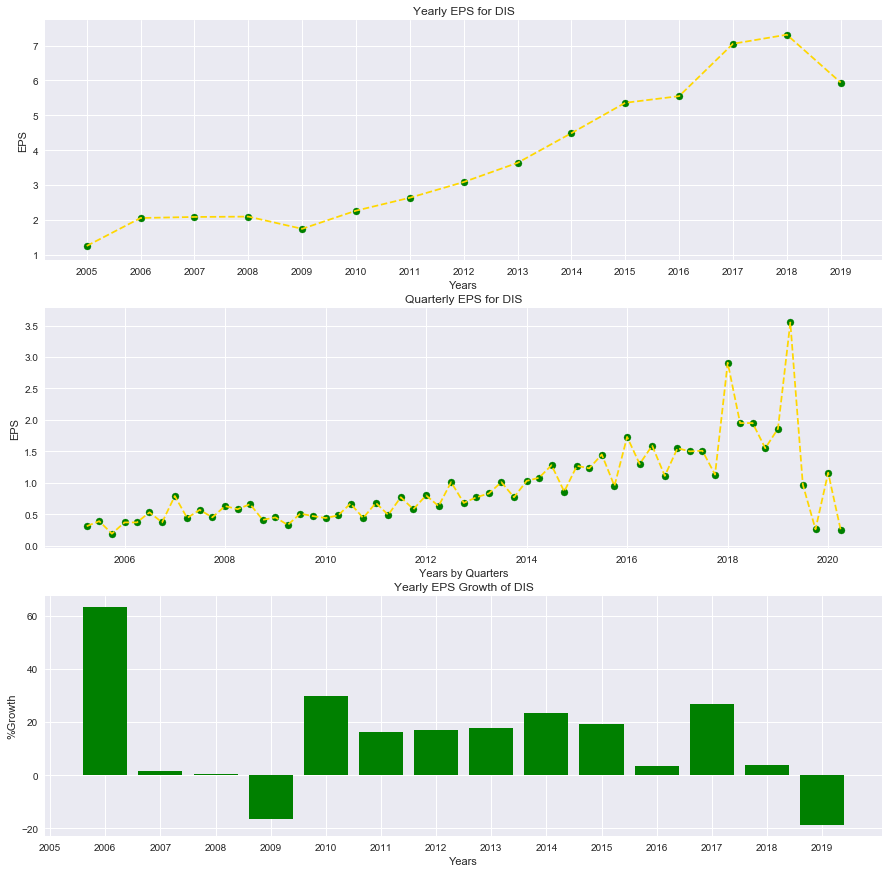

In [65]:
#Plots for Quarterly and Yearly EPS 
plt.style.use('seaborn')
fig,(ax7,ax8,ax9) = plt.subplots(nrows = 3,ncols = 1,figsize = (15,15))

#Plots the Yearly EPS 
ax7.plot(yearlyEPS['Date'],yearlyEPS['EPS'],color = 'gold',linestyle = 'dashed')
ax7.scatter(yearlyEPS['Date'],yearlyEPS['EPS'],color = 'green')
ax7.set_title('Yearly EPS for {0}'.format(user_stock))
ax7.set_ylabel('EPS')
ax7.set_xlabel('Years')

#Plots the Quarterly EPS
ax8.plot(quarterlyEPS['Dates'],quarterlyEPS['EPS'],color = 'gold',linestyle = 'dashed')
ax8.scatter(quarterlyEPS['Dates'],quarterlyEPS['EPS'],color = 'green')
ax8.set_title('Quarterly EPS for {0}'.format(user_stock))
ax8.set_ylabel('EPS')
ax8.set_xlabel('Years by Quarters')

#Plots Yearly EPS Percent Change

ax9.bar(yearlyEPS['Date'],epsPercentYearly,color = 'g')
ax9.set_xlabel('Years')
ax9.set_ylabel('%Growth')
ax9.set_title('Yearly EPS Growth of {0}'.format(user_stock))
